In [12]:
from mnist import load_mnist
import matplotlib.pyplot as plt
import numpy as np

In [13]:
#!pip install scikit-learn

I. Датасет:

In [14]:
# Загрузка данных MNIST
train, validation, test = load_mnist()

# Извлечение данных для обучающего набора
X_train, y_train = train
X_validation, y_validation = validation
X_test, y_test = test

print("Форма обучающих данных:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"Метки: {np.unique(y_train)}")

Extracting MNIST-data\train-images-idx3-ubyte.gz
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz
Форма обучающих данных:
X_train: (55000, 28, 28, 1)
y_train: (55000,)
Метки: [0 1 2 3 4 5 6 7 8 9]


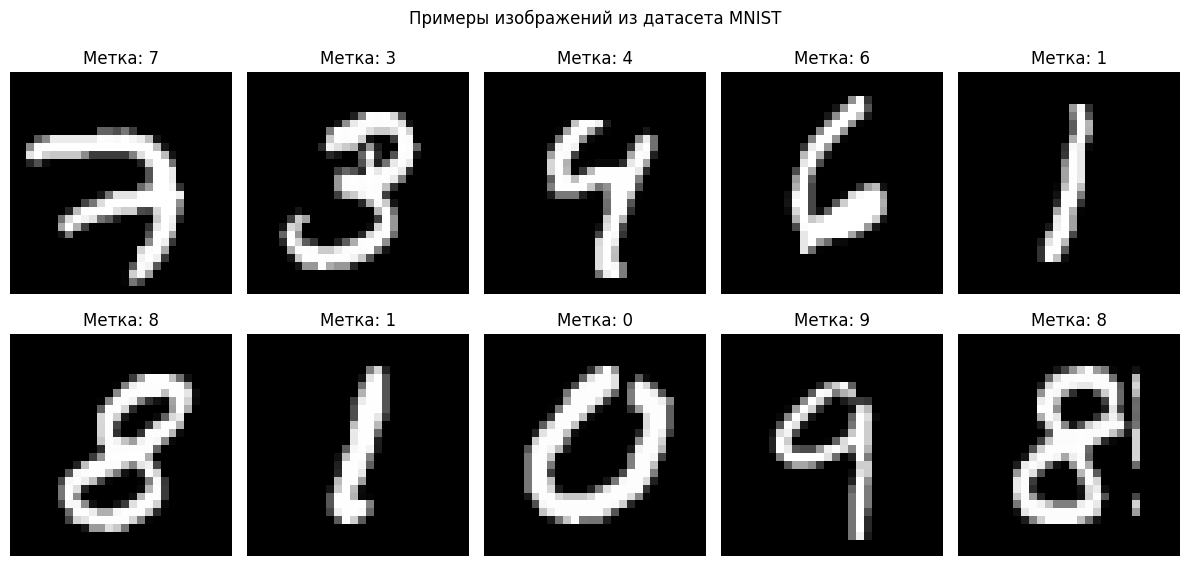

In [15]:
# 2. Визуализация нескольких примеров картинок
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Примеры изображений из датасета MNIST')

# Отображаем 10 примеров
for i in range(10):
    row = i // 5 #division without rem.
    col = i % 5 #remainder
    
    # Отображаем изображение
    axes[row, col].imshow(X_train[i].reshape(28, 28), cmap='gray')
    axes[row, col].set_title(f'Метка: {y_train[i]}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

II. Алгоритм PCA:

In [16]:
import numpy as np
#We find the axes, which explain the data better in terms of the variance. Then project my data onto those new axes.
class my_PCA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.mean = None
        self.components = None
        self.explained_variance = None

    def fit(self, X):
        # 1) Центрируем данные
        self.mean = np.mean(X, axis=0)  #column means
        X_centered = X - self.mean

        # 2) Вычисляем матрицу ковариации
        C = np.cov(X_centered, rowvar=False)  # rowvar = false > each column represents a variable

        # 3) Находим собственные векторы и значения
        eig_vals, eig_vecs = np.linalg.eigh(C)

        # сортируем по убыванию
        idx = np.argsort(eig_vals)[::-1] #sort eig_vals in desc order
        eig_vals = eig_vals[idx]
        eig_vecs = eig_vecs[:, idx] #: all the values from each vectors

        # сохраняем компоненты
        if self.n_components is not None:
            eig_vecs = eig_vecs[:, :self.n_components] #only the first n vectors
            eig_vals = eig_vals[:self.n_components]

        self.components = eig_vecs
        self.explained_variance = eig_vals / np.sum(eig_vals) #normalizamos de 0 a 1

    def transform(self, X):
        # 4) Преобразование данных
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)


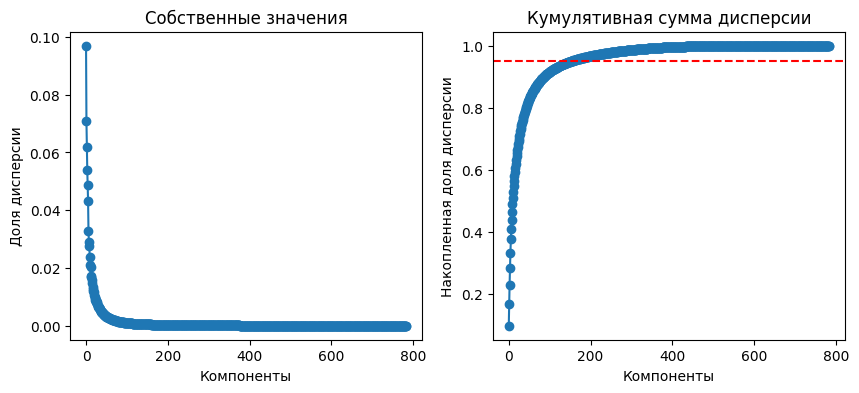

Первые 15 компонент покрывают: 0.5791247436307821


In [17]:
import matplotlib.pyplot as plt
import numpy as np

# обучим PCA на тренировочных данных
pca = my_PCA()
pca.fit(X_train.reshape(len(X_train), -1))  # разворачиваем картинки в векторы (-1)

# собственные значения
eig_vals = pca.explained_variance

# график собственных значений
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(eig_vals, marker="o")
plt.title("Собственные значения")
plt.xlabel("Компоненты")
plt.ylabel("Доля дисперсии")

# кумулятивная сумма
cum_sum = np.cumsum(eig_vals)

plt.subplot(1, 2, 2)
plt.plot(cum_sum, marker="o")
plt.axhline(y=0.95, color="r", linestyle="--")  # линия для 95% дисперсии
plt.title("Кумулятивная сумма дисперсии")
plt.xlabel("Компоненты")
plt.ylabel("Накопленная доля дисперсии")
plt.show()

print("Первые 15 компонент покрывают:",
      np.sum(eig_vals[:15]))


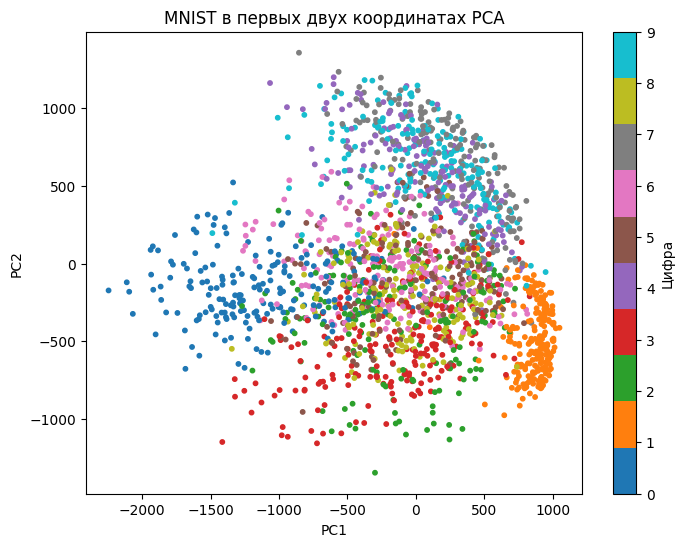

In [18]:
# уменьшаем до 2D
pca2 = my_PCA(n_components=2)
X_proj = pca2.fit(X_train.reshape(len(X_train), -1))
X_proj = pca2.transform(X_train.reshape(len(X_train), -1))

# берём только первые 2000 точек, чтобы не перегружать график
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_proj[:2000, 0], X_proj[:2000, 1],
                      c=y_train[:2000], cmap="tab10", s=10)
plt.colorbar(scatter, label="Цифра")
plt.title("MNIST в первых двух координатах PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


Некоторые классы хорошо отделяются: например, цифры 0 часто образуют плотное облако, отделённое от других.

Многие классы сильно перекрываются: цифры 3 и 5, 4 и 9, 7 и 9 накладываются друг на друга.

В целом, полной линейной разделимости нет: то есть нельзя провести прямые линии и чётко разделить все цифры в плоскости (PC1, PC2).

PCA выбирает направления максимальной дисперсии данных, но это не обязательно совпадает с направлениями, которые лучше всего разделяют классы.

III. Алгоритм kNN:

In [19]:
#1. Реализация метода k-ближайших соседей
import numpy as np

class my_kNN:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X): # X - unseen data
        predictions = []
        for x in X: # going over each picture
            # считаем евклидово расстояние до всех точек обучающей выборки
            distances = np.linalg.norm(self.X_train - x, axis=1)
            
            # выбираем индексы k ближайших соседей
            neighbors_idx = np.argsort(distances)[:self.n_neighbors] #asc
            
            # смотрим метки соседей
            neighbor_labels = self.y_train[neighbors_idx]
            
            # выбираем наиболее частый класс
            values, counts = np.unique(neighbor_labels, return_counts=True) #dictionary of classes and counts
            majority_class = values[np.argmax(counts)]
            predictions.append(majority_class)
        return np.array(predictions)


In [20]:
#2. Разделим данные на train и test
from sklearn.model_selection import train_test_split

X = X_train.reshape(len(X_train), -1)
y = y_train
# возьмем меньше данных для ускорения (например, 10000 образцов)
X_small, _, y_small, _ = train_test_split(X, y, train_size=10000, stratify=y) #stratify: mantiene la proporcion de clases

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_small, y_small, test_size=0.2, stratify=y_small)

In [21]:
#3. Обучение и проверка точности
from sklearn.metrics import accuracy_score

knn = my_kNN(n_neighbors=5)
knn.fit(X_train_knn, y_train_knn)

y_pred = knn.predict(X_test_knn)

acc = accuracy_score(y_test_knn, y_pred)
print("Точность kNN (k=5):", acc)


Точность kNN (k=5): 0.2475


In [22]:
#4. Снижение размерности с помощью PCA + kNN
# используем ранее реализованный my_PCA
results = {}

for n_components in [2, 10, 20, 30, 50, 64]:
    pca = my_PCA(n_components=n_components)
    pca.fit(X_train_knn)
    
    X_train_pca = pca.transform(X_train_knn)
    X_test_pca = pca.transform(X_test_knn)
    
    for k in [1, 3, 5, 10, 15, 20, 30]:
        knn = my_kNN(n_neighbors=k)
        knn.fit(X_train_pca, y_train_knn)
        y_pred = knn.predict(X_test_pca)
        acc = accuracy_score(y_test_knn, y_pred)
        results[(n_components, k)] = acc
        print(f"Components={n_components}, k={k}, accuracy={acc:.4f}")


Components=2, k=1, accuracy=0.3790
Components=2, k=3, accuracy=0.4055
Components=2, k=5, accuracy=0.4300
Components=2, k=10, accuracy=0.4390
Components=2, k=15, accuracy=0.4480
Components=2, k=20, accuracy=0.4490
Components=2, k=30, accuracy=0.4510
Components=10, k=1, accuracy=0.8885
Components=10, k=3, accuracy=0.8925
Components=10, k=5, accuracy=0.9025
Components=10, k=10, accuracy=0.9070
Components=10, k=15, accuracy=0.9070
Components=10, k=20, accuracy=0.9005
Components=10, k=30, accuracy=0.8985
Components=20, k=1, accuracy=0.9440
Components=20, k=3, accuracy=0.9435
Components=20, k=5, accuracy=0.9460
Components=20, k=10, accuracy=0.9425
Components=20, k=15, accuracy=0.9420
Components=20, k=20, accuracy=0.9395
Components=20, k=30, accuracy=0.9295
Components=30, k=1, accuracy=0.9555
Components=30, k=3, accuracy=0.9510
Components=30, k=5, accuracy=0.9515
Components=30, k=10, accuracy=0.9455
Components=30, k=15, accuracy=0.9390
Components=30, k=20, accuracy=0.9405
Components=30, k=30,

Выводы к работе

Простая реализация kNN уже даёт высокую точность на MNIST.

Снижение размерности с помощью PCA позволяет ускорить работу алгоритма, почти не теряя точность.

Обычно:

При n_components ≈ 30–50 достигается хорошая компромисс между скоростью и точностью.

Оптимальное значение k часто лежит в диапазоне 3–7.

Линейная разделимость классов в 2D (PC1, PC2) слабая, но с увеличением числа компонент разделимость улучшается.